# Lab 2: 线性回归

## 1. 使用Pandas读取广告数据

In [1]:
import os
import sys
import pandas as pd

path = os.path.dirname(os.getcwd())
sys.path.append(path)

from common.filesio import FilesIO

# 在read_csv()的时候，系统会默认第一列是第一个字段而不是索引（index），这样在保存的时候就会凭空多处一列index
# 用index_col表示哪列是索引列, 用作 DataFrame 行标签的列，以字符串名称或列索引的形式给出
data = pd.read_csv(FilesIO.getLectureData('Advertising.csv'), index_col=0) 

In [2]:
print(data.head()) # 显示前5项数据
print(data.tail()) # 显示最后5项数据
print(data.shape)  # 查看DataFame的维度

      TV  radio  newspaper  sales
1  230.1   37.8       69.2   22.1
2   44.5   39.3       45.1   10.4
3   17.2   45.9       69.3    9.3
4  151.5   41.3       58.5   18.5
5  180.8   10.8       58.4   12.9
        TV  radio  newspaper  sales
196   38.2    3.7       13.8    7.6
197   94.2    4.9        8.1    9.7
198  177.0    9.3        6.4   12.8
199  283.6   42.0       66.2   25.5
200  232.1    8.6        8.7   13.4
(200, 4)


## 2. 探索性分析：使用散点图可视化特征与输出Y之间相关性

推荐使用seaborn包，数据可视化效果比较好。seaborn的pairplot函数默认绘制X的每一维度和对应Y的散点图。

https://seaborn.pydata.org/generated/seaborn.pairplot.html

pairplot函数：seaborn.pairplot(data, *, hue=None, hue_order=None, palette=None, vars=None, x_vars=None, y_vars=None, kind='scatter', diag_kind='auto', markers=None, height=2.5, aspect=1, corner=False, dropna=False, plot_kws=None, diag_kws=None, grid_kws=None, size=None)

主要参数：
x_vars: x轴代表的变量（特征）名

y_vars: y轴代表的变量名

kind: 图的类型。可取值{‘scatter’, ‘kde’, ‘hist’, ‘reg’}

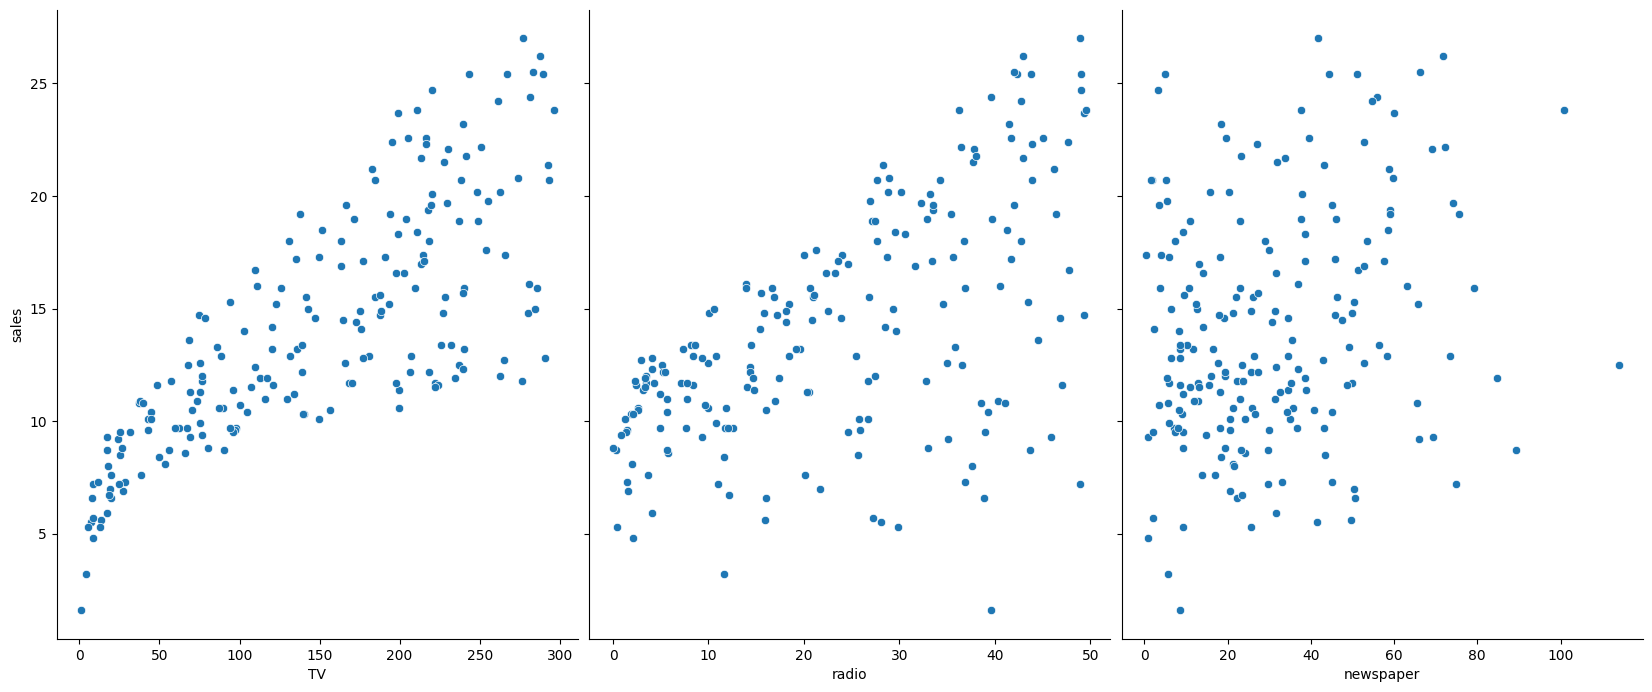

In [3]:
import seaborn as sns
import matplotlib.pyplot as plt

# visualize the relationship between the features and the response using scatterplots
sns.pairplot(data, x_vars=['TV','radio','newspaper'], y_vars='sales', height = 7, aspect=0.8)
plt.show() # 显示图片，必须加上这一句，否则无法显示

通过加入一个参数kind='reg'，seaborn可以添加一条最佳拟合直线和95%的置信带。

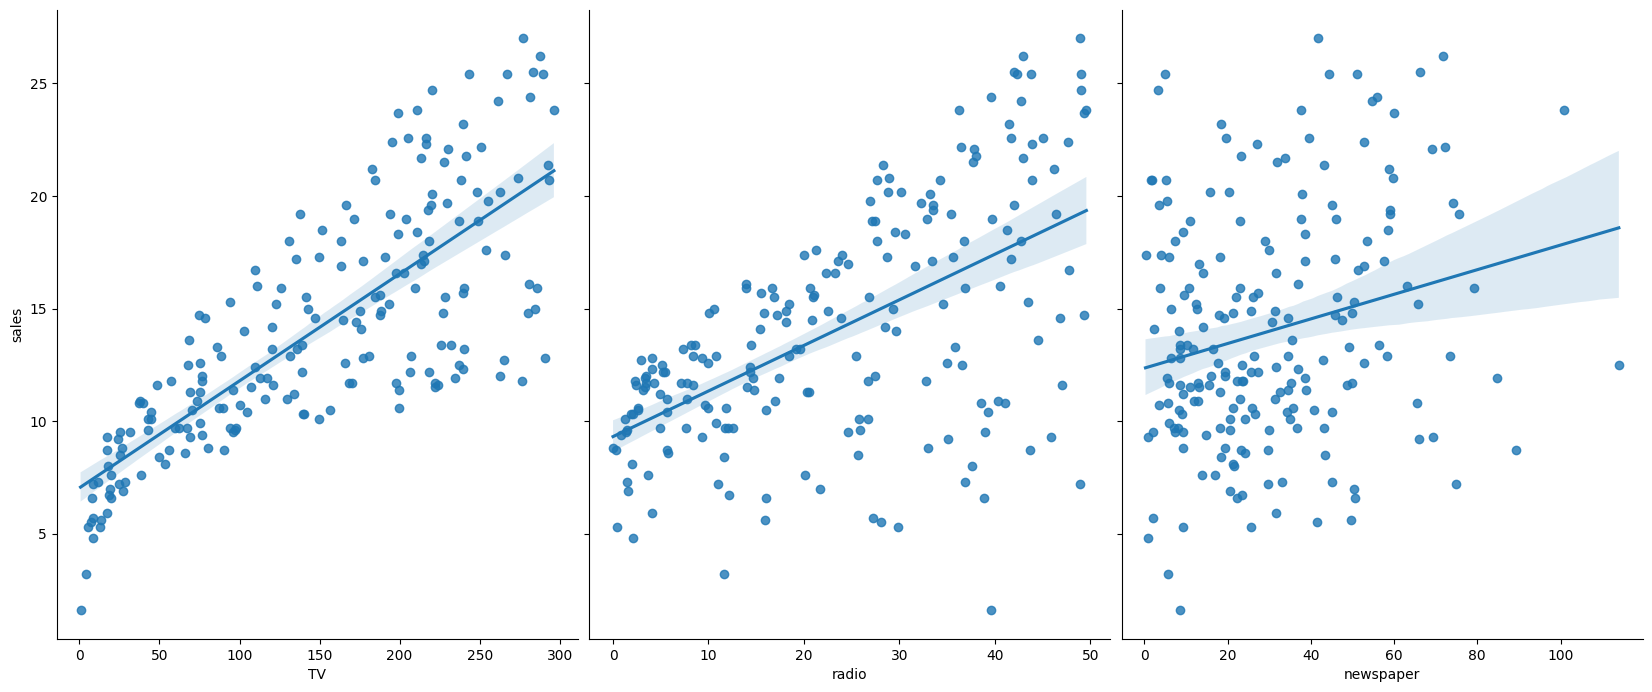

In [4]:
sns.pairplot(data, x_vars=['TV','radio','newspaper'], y_vars='sales', height = 7, aspect=0.8, kind='reg')
plt.show() # 必须加上这一句，否则无法显示

## 3. 线性回归模型

scikit-learn (sklearn)是一个Python第三方提供的非常强力的机器学习库 https://scikit-learn.org/stable/

### 3.1 使用pandas构建X（特征）和 y (输出/目标变量)

scikit-learn要求X是一个特征矩阵，y是一个NumPy向量。pandas构建在NumPy之上。X可以是pandas的DataFrame， y可以是pandas的Series，scikit-learn可以理解这种结构。

#### 构建X： 选取TV, radio, newspaper作为特征

In [5]:
#创建特征列表
feature_cols = ['TV', 'radio', 'newspaper']

# 构建特征矩阵X, 它是原始数据data的一个子集，提取列名在feature_cols中的变量
X = data[feature_cols]

#使用列表选择原始DataFrame的子集
X = data[['TV', 'radio', 'newspaper']] ## 和上面两行等价

In [6]:
print(X.head()) # 输出前五项数据
print(type(X)) # X的类型
print(X.shape) # X的维数

      TV  radio  newspaper
1  230.1   37.8       69.2
2   44.5   39.3       45.1
3   17.2   45.9       69.3
4  151.5   41.3       58.5
5  180.8   10.8       58.4
<class 'pandas.core.frame.DataFrame'>
(200, 3)


In [7]:
X.columns ## 索引：特征名

Index(['TV', 'radio', 'newspaper'], dtype='object')

#### 构建y: 选取sales作为输出变量

In [8]:
#从DataFrame中选择一个Series
y = data['sales']
y = data.sales # 和上面一行等价

In [9]:
# 输出前五项数据
print(y.head())

print(type(y))
print(y.shape)

1    22.1
2    10.4
3     9.3
4    18.5
5    12.9
Name: sales, dtype: float64
<class 'pandas.core.series.Series'>
(200,)


### 3.2 构建训练集和测试集

构建训练集和测试集，分别保存在X_train, y_train, Xtest和y_test中。

#### 方法一：指定前多少行为训练集，剩下的行为测试集

对DataFrame数据, [ ]中的值代表对行进行切割. 

In [10]:
## 特征
X_train = X[:150]; # 用前150行为训练集
X_test = X[150:];  # 用151-120行为测试集
X_train;
X_test;

## 输出
y_train = y[:150]
y_test = y[150:]
y_train;
y_test;

In [11]:
X_train.shape

(150, 3)

In [12]:
X_train.head()

,TV,radio,newspaper
1,230.1,37.8,69.2
2,44.5,39.3,45.1
3,17.2,45.9,69.3
4,151.5,41.3,58.5
5,180.8,10.8,58.4


In [13]:
X_test.head()

,TV,radio,newspaper
151,280.7,13.9,37.0
152,121.0,8.4,48.7
153,197.6,23.3,14.2
154,171.3,39.7,37.7
155,187.8,21.1,9.5


#### 方法二：随机生成训练集和测试集

使用函数train_test_split 
https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html

train_test_split函数：sklearn.model_selection.train_test_split(*arrays, test_size=None, train_size=None, random_state=None, shuffle=True, stratify=None)

主要参数：
*arrays：X, y

test_size: 测试集大小。可以是(0,1)之间的小数，代表测试集占总数据集的比例；也可以是整数，代表测试集中的实例数。默认为None，代表test_size=0.25 (即测试集占25%数据)

train_size: 训练集大小。

random_state: 随机种子。整数。不同的数生成的数据不同

In [14]:
from sklearn.model_selection import train_test_split # 随机生成训练集和测试集

# 75% 用于训练， 25%用于测试
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state=1) 

# X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)  # 与前一行等价

# X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=2)  

In [15]:
import pandas as pd
pd.DataFrame(X_train).head()


,TV,radio,newspaper
99,289.7,42.3,51.2
124,123.1,34.6,12.4
120,19.4,16.0,22.3
54,182.6,46.2,58.7
34,265.6,20.0,0.3


In [16]:
X_test.head()

,TV,radio,newspaper
59,210.8,49.6,37.7
41,202.5,22.3,31.6
35,95.7,1.4,7.4
103,280.2,10.1,21.4
185,253.8,21.3,30.0


In [17]:
y_train.head()

99     25.4
124    15.2
120     6.6
54     21.2
34     17.4
Name: sales, dtype: float64

In [18]:
y_test.head()

59     23.8
41     16.6
35      9.5
103    14.8
185    17.6
Name: sales, dtype: float64

### Q: 
### 1. 请修改random_state的值，看X_train的前5行是否相同。
### 2. 请删掉random_state这一项，多次运行train_test_split看X_train的前5行是否相同

### 3.3 使用sklearn进行线性回归

使用sklearn.linear_model中的LinearRegression函数进行线性回归，它使用最小二乘法（正规方程）求解。

https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html#sklearn.linear_model.LinearRegression

In [19]:
from sklearn.linear_model import LinearRegression

LinearRegression函数：sklearn.linear_model.LinearRegression(*, fit_intercept=True, normalize='deprecated', copy_X=True, n_jobs=None, positive=False)

主要参数：

fit_intercept: 是否有截距项，默认有。

### step 1: 定义线性回归模型

In [20]:
linreg = LinearRegression() ## 使用默认参数设置

### step 2: 在训练集上训练（拟合fit）线性回归模型

fit函数：fit(X, y, sample_weight=None) 

https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html#sklearn.linear_model.LinearRegression.fit

In [21]:
linreg.fit(X_train, y_train)

LinearRegression()

### step 3: 查看在训练集上估计的线性回归参数

intercept_: 截距值，即$\theta_0$

coef_: 与特征相对于的参数值， 即$\theta_1, \dots, \theta_p$

In [22]:
print (linreg.intercept_)
print (linreg.coef_)

2.8769666223179335
[0.04656457 0.17915812 0.00345046]


#### 将特征名称与参数相对应: 利用pandas的DataFrame

pandas.DataFrame(data=None, index=None, columns=None, dtype=None, copy=None)

In [23]:
pd.DataFrame(data = linreg.coef_, index = X.columns, columns = ['coef']) ## 用特征名(X.columns)作为索引

,coef
TV,0.046565
radio,0.179158
newspaper,0.003450


保留三位小数，线性回归结果： predicted sales = 2.877 + 0.047TV + 0.179Radio + 0.003Newspaper

### 如何解释线性回归模型参数 （重要！！）

### Step 4: 在测试集上做预测

predict函数：predict(X) 用线性回归做预测

In [24]:
y_pred = linreg.predict(X_test)

## 4. 评价模型（在测试集上）

主要评价回归模型的指标：

MSE (mean squared error): 均方误差

RMSE （root mean squared error): 均方根误差

$R^2$: 可决系数 (coefficient of determination) $=1-\frac{u}{v}$, 残差平方和u=((y_true - y_pred)** 2).sum(), 总平方和v=((y_true - y_true.mean()) ** 2).sum(). 值在0-1之间，值越大越好 https://baike.baidu.com/item/%E5%8F%AF%E5%86%B3%E7%B3%BB%E6%95%B0/8020809


### 4.1 MSE, RMSE

In [25]:
from sklearn import metrics
import numpy as np

MSE = metrics.mean_squared_error(y_test, y_pred) ## 均方误差
RMSE = np.sqrt(MSE) # 均方根误差

In [26]:
print(MSE)
print(RMSE)

1.9730456202283404
1.4046514230328961


In [27]:
print('MSE为:',"%.3f" % MSE) ## 保留三位小数

MSE为: 1.973


### 4.2 $R^2$ 可决系数

In [28]:
R2 = linreg.score(X_test, y_test)
print(R2)

0.9156213613792231


### 4.3 可视化： 画出在测试集上的预测值和真实值Y的对比图

plot函数：https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.plot.html

### 方法一：在同一张图中分别画出预测值的线和真实值的线

#### 横坐标x代表测试集中的第几个商品，纵坐标y代表商品对应的预测值或真实值

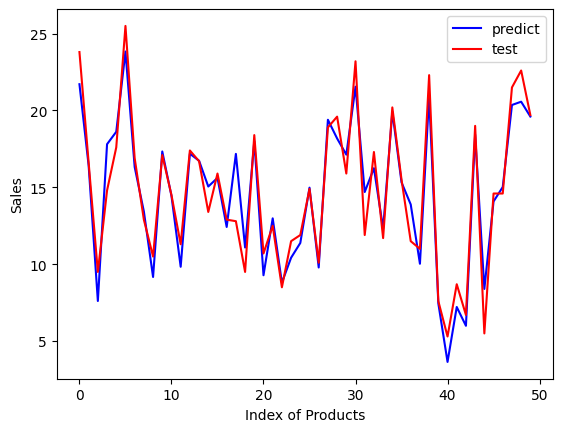

In [29]:
plt.figure()
plt.plot(range(len(y_pred)), np.array(y_pred), 'b',label="predict") ## 预测值用蓝色线表示
plt.plot(range(len(y_pred)), np.array(y_test), 'r',label="test") ## 真实值用红色线表示
plt.legend(loc="upper right") #显示图中的标签
plt.xlabel("Index of Products")
plt.ylabel('Sales')
plt.show()

### 方法二：预测值 vs 真实值

#### 横坐标代表真实值，纵坐标代表预测值 (可以交换)

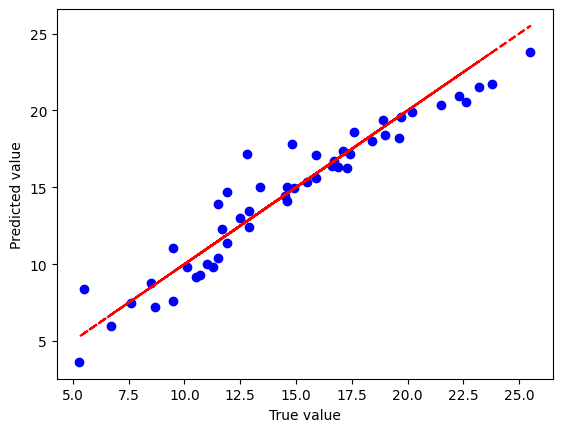

In [30]:
plt.figure()
plt.plot(np.array(y_test),np.array(y_pred), 'bo',label="predict") ## bo: 蓝色的圈
plt.plot(np.array(y_test),np.array(y_test), 'r--',label="true") ## r--: 红色虚线
plt.xlabel("True value")
plt.ylabel('Predicted value')
plt.show()

## 5. 特征缩放

### 5.1 标准化 (standardization): 注意! 需要训练集、测试集分开进行

使用sklearn.preprocessing中的StandardScaler函数：对特征减去均值并除以标准差

sklearn.preprocessing.StandardScaler(*, copy=True, with_mean=True, with_std=True)

https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html

In [31]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler() ## 定义使用标准化做缩放

X_train = scaler.fit_transform(X_train) ## 在训练数据上计算均值、标准差，并将其标准化

X_test = scaler.fit_transform(X_test) ## 在测试数据上计算均值、标准差，并将其标准化

#### 在标准化后的数据上训练线性回归模型

In [32]:
linreg.fit(X_train, y_train)

LinearRegression()

#### 系数有什么变化？ 

In [33]:
print(linreg.intercept_) ## 截距

13.810666666666666


In [34]:
pd.DataFrame(data = linreg.coef_, index = X.columns, columns = ['coef']) ## 用特征名(X.columns)作为索引

,coef
TV,4.062053
radio,2.709847
newspaper,0.073444


#### Q： 如何解释参数？

### 5.2 最大最小化 (MinMax): 注意! 需要训练集、测试集分开进行

使用sklearn.preprocessing中的MinMaxScaler函数: (x-min(x))/(max(x)-min(x))

https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html

In [35]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state=1)  

min_max_scaler = MinMaxScaler()

X_train = min_max_scaler.fit_transform(X_train)

X_test = min_max_scaler.fit_transform(X_test)

#### Q: 请尝试在最大最小化后的数据上训练线性回归模型

## 6. 如果有分类变量 （categorical variable）

In [36]:
import pandas as pd

data = pd.read_csv("D:/python_project/some_code/Study/Machine_Learning/data/Wage.csv")

In [37]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Data columns (total 11 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   year        3000 non-null   int64  
 1   age         3000 non-null   int64  
 2   maritl      3000 non-null   object 
 3   race        3000 non-null   object 
 4   education   3000 non-null   object 
 5   region      3000 non-null   object 
 6   jobclass    3000 non-null   object 
 7   health      3000 non-null   object 
 8   health_ins  3000 non-null   object 
 9   logwage     3000 non-null   float64
 10  wage        3000 non-null   float64
dtypes: float64(2), int64(2), object(7)
memory usage: 257.9+ KB


In [38]:
feature_cols = ['year', 'age', 'maritl', 'race', 'education', 'region', 'jobclass', 'health', 'health_ins']
X = data[feature_cols];

X.head()

,year,age,maritl,race,education,region,jobclass,health,health_ins
0,2006,18,1. Never Married,1. White,1. < HS Grad,2. Middle Atlantic,1. Industrial,1. <=Good,2. No
1,2004,24,1. Never Married,1. White,4. College Grad,2. Middle Atlantic,2. Information,2. >=Very Good,2. No
2,2003,45,2. Married,1. White,3. Some College,2. Middle Atlantic,1. Industrial,1. <=Good,1. Yes
3,2003,43,2. Married,3. Asian,4. College Grad,2. Middle Atlantic,2. Information,2. >=Very Good,1. Yes
4,2005,50,4. Divorced,1. White,2. HS Grad,2. Middle Atlantic,2. Information,1. <=Good,1. Yes


### 解决方法：将categorical variable变成哑变量/虚拟变量 (dummy variable)

使用pandas的get_dummies函数。

pandas.get_dummies(data, prefix=None, prefix_sep='_', dummy_na=False, columns=None, sparse=False, drop_first=False, dtype=None)

https://pandas.pydata.org/docs/reference/api/pandas.get_dummies.html

主要参数：

drop_first: 是否删除第一个级别，使得从k个分类级别中获取k-1个虚拟变量。默认False

columns: 数据中需要变成虚拟变量的变量名（列名）。默认None，表示将数据中所有具有object(对象数据),string（字符串）或category（类别）数据类型的列都转换成虚拟变量

In [39]:
dum_X = pd.get_dummies(X, drop_first=True,dtype=int)
dum_X.head()

,year,age,maritl_2. Married,maritl_3. Widowed,maritl_4. Divorced,maritl_5. Separated,race_2. Black,race_3. Asian,race_4. Other,education_2. HS Grad,education_3. Some College,education_4. College Grad,education_5. Advanced Degree,jobclass_2. Information,health_2. >=Very Good,health_ins_2. No
0,2006,18,0,0,0,0,0,0,0,0,0,0,0,0,0,1
1,2004,24,0,0,0,0,0,0,0,0,0,1,0,1,1,1
2,2003,45,1,0,0,0,0,0,0,0,1,0,0,0,0,0
3,2003,43,1,0,0,0,0,1,0,0,0,1,0,1,1,0
4,2005,50,0,0,1,0,0,0,0,1,0,0,0,1,0,0


In [40]:
dum_X2 = pd.get_dummies(X) ## drop_fist = False
dum_X2.head()

,year,age,maritl_1. Never Married,maritl_2. Married,maritl_3. Widowed,maritl_4. Divorced,maritl_5. Separated,race_1. White,race_2. Black,race_3. Asian,...,education_3. Some College,education_4. College Grad,education_5. Advanced Degree,region_2. Middle Atlantic,jobclass_1. Industrial,jobclass_2. Information,health_1. <=Good,health_2. >=Very Good,health_ins_1. Yes,health_ins_2. No
0,2006,18,1,0,0,0,0,1,0,0,...,0,0,0,1,1,0,1,0,0,1
1,2004,24,1,0,0,0,0,1,0,0,...,0,1,0,1,0,1,0,1,0,1
2,2003,45,0,1,0,0,0,1,0,0,...,1,0,0,1,1,0,1,0,1,0
3,2003,43,0,1,0,0,0,0,0,1,...,0,1,0,1,0,1,0,1,1,0
4,2005,50,0,0,0,1,0,1,0,0,...,0,0,0,1,0,1,1,0,1,0


In [41]:
dum_X2.columns

Index(['year', 'age', 'maritl_1. Never Married', 'maritl_2. Married',
       'maritl_3. Widowed', 'maritl_4. Divorced', 'maritl_5. Separated',
       'race_1. White', 'race_2. Black', 'race_3. Asian', 'race_4. Other',
       'education_1. < HS Grad', 'education_2. HS Grad',
       'education_3. Some College', 'education_4. College Grad',
       'education_5. Advanced Degree', 'region_2. Middle Atlantic',
       'jobclass_1. Industrial', 'jobclass_2. Information', 'health_1. <=Good',
       'health_2. >=Very Good', 'health_ins_1. Yes', 'health_ins_2. No'],
      dtype='object')

### 当特征有分类变量时，调用线性回归模型LinearRegression时的X应为：

### X = pd.get_dummies(X, drop_first=True)

### Q: 如何解释分类变量对应的参数？

例：$h(x)=\theta_0+\theta_1I(education = 2.HS Grad)+\theta_2I(education = 3.Some college)+\theta_3I(education = 4. Colledge Grad)+\theta_4I(education = 5.Advanced Degree)+\theta_5(health = 2.>=Very Good)$